In [1]:
import json
import csv
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import seaborn as sns

## Trae Body por vendedor

In [2]:
raw_data = pd.read_json('A2-Mascarillas.json')

raw_data.rename(columns={ raw_data.columns[0]: "id_meli" }, inplace = True)
print(raw_data.shape)

raw_data['domain_id'] = raw_data['domain_id'].apply(lambda x: str(x).replace('MLA-', '').replace('_', ' '))

print(raw_data.columns)


(1000, 34)
Index(['id_meli', 'site_id', 'title', 'seller', 'price', 'prices',
       'sale_price', 'currency_id', 'available_quantity', 'sold_quantity',
       'buying_mode', 'listing_type_id', 'stop_time', 'condition', 'permalink',
       'thumbnail', 'thumbnail_id', 'accepts_mercadopago', 'installments',
       'address', 'shipping', 'seller_address', 'attributes', 'original_price',
       'category_id', 'official_store_id', 'domain_id', 'catalog_product_id',
       'tags', 'order_backend', 'use_thumbnail_id', 'fecha_publicacion',
       'health', 'differential_pricing'],
      dtype='object')


In [3]:
raw_data = raw_data[~raw_data['title'].str.contains('Vela', regex=False)]
raw_data = raw_data[~raw_data['title'].str.contains('Aditivo Mejorador', regex=False)]
raw_data = raw_data[~raw_data['title'].str.contains('Cera De Soja', regex=False)]
raw_data = raw_data[~raw_data['title'].str.contains('Medidora', regex=False)]
raw_data = raw_data[~raw_data['title'].str.contains('Dolor', regex=False)]
raw_data = raw_data[raw_data['sold_quantity'] != 0]

print(raw_data.shape)

(994, 34)


In [4]:
raw_data['id_custom'] = raw_data['id_meli'].apply(lambda x: 'MLA-' + str(x).split('MLA')[1])
mask_no_catalogo = raw_data.apply(lambda x: str(x.id_custom) in x.permalink, axis=1)
raw_data = raw_data[mask_no_catalogo]
raw_data.shape

(994, 35)

In [5]:
raw_data['fecha_publicacion'] =  pd.to_datetime(raw_data['fecha_publicacion'])
## x = pd.to_datetime(raw_data['fecha_publicacion'][0])
x = pd.to_datetime('2017-09-24T15:04:22.000Z')

today = datetime.now(tz=x.tz)
raw_data['meses_venta'] = ((today - raw_data['fecha_publicacion']) / np.timedelta64(1, 'M'))

raw_data['ventas_mes'] = (raw_data['sold_quantity'] / raw_data['meses_venta']).round(0).astype(int)

raw_data['fact_mes'] = (raw_data['price'] * raw_data['ventas_mes']).round(0).astype(int)

In [6]:
raw_data.columns


Index(['id_meli', 'site_id', 'title', 'seller', 'price', 'prices',
       'sale_price', 'currency_id', 'available_quantity', 'sold_quantity',
       'buying_mode', 'listing_type_id', 'stop_time', 'condition', 'permalink',
       'thumbnail', 'thumbnail_id', 'accepts_mercadopago', 'installments',
       'address', 'shipping', 'seller_address', 'attributes', 'original_price',
       'category_id', 'official_store_id', 'domain_id', 'catalog_product_id',
       'tags', 'order_backend', 'use_thumbnail_id', 'fecha_publicacion',
       'health', 'differential_pricing', 'id_custom', 'meses_venta',
       'ventas_mes', 'fact_mes'],
      dtype='object')

In [7]:
def BuscarMarca(attributes_list):
    for este_atributo in attributes_list:
        if este_atributo['id'] == 'BRAND':
            return este_atributo['values'][0]['name']
    return 'Sin marca'

In [8]:
raw_data['Marca'] = raw_data['attributes'].apply(BuscarMarca)
raw_data['Marca'].isna().sum()

0

In [9]:
na_mask = raw_data['Marca'].isna()
raw_data['Marca'] = raw_data['Marca'].replace(np.nan, '', regex=True)

In [10]:
def BuscarSeller(data):
    
    return data['permalink'].split('/')[-1]

raw_data['Vendedor'] = raw_data['seller'].apply(BuscarSeller)

## Ver data

(994, 40)
(709, 40)


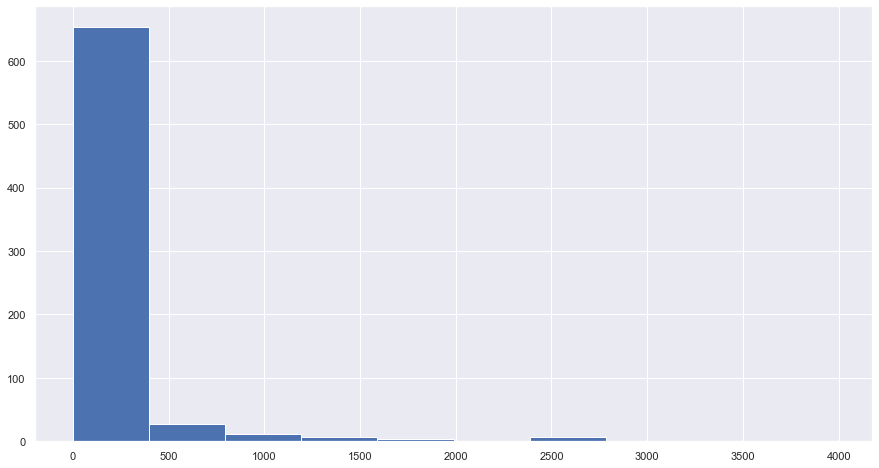

In [31]:
top_sellers = raw_data[raw_data['ventas_mes'] > 0]
top_sellers = top_sellers[top_sellers['price'] < 2000]
top_sellers['sold_quantity'].hist()
print(raw_data.shape)
print(top_sellers.shape)

In [32]:
top_sellers['ventas_mes'].describe()

count    709.000000
mean      13.221439
std       31.242496
min        1.000000
25%        1.000000
50%        4.000000
75%       11.000000
max      408.000000
Name: ventas_mes, dtype: float64

In [41]:
por_marcas = top_sellers.groupby('title') \
       .agg({'title':'size', 'price':'mean', 'sold_quantity':'mean', 'meses_venta':'mean', 'ventas_mes':'sum', 'fact_mes':'sum'}) \
       .rename(columns={
    'title':'count', 
    'price':'precio_medio', 
    'sold_quantity':'venta_media', 
    'meses_venta':'meses_venta',
    'ventas_mes':'ventas_mes',
    'fact_mes':'fact_mes'}) \
       .reset_index()

por_marcas['precio_medio'] = por_marcas['precio_medio'].round(0).astype(int)
por_marcas['venta_media'] = por_marcas['venta_media'].round(0).astype(int)
por_marcas['meses_venta'] = por_marcas['meses_venta'].round(0).astype(int)
por_marcas['ventas_mes'] = por_marcas['ventas_mes'].round(0).astype(int)
por_marcas['fact_mes'] = por_marcas['fact_mes'].round(0).astype(int)

por_marcas.sort_values(by='ventas_mes', ascending=False).tail(30)

,title,count,precio_medio,venta_media,meses_venta,ventas_mes,fact_mes
378,Mascarilla Facial De Tela Colageno Antiage Rea...,1,405,4,5,1,405
377,Mascarilla Facial De Limpieza Profunda Carbon ...,1,1474,9,14,1,1474
333,Mascarilla Facial Colágeno Hidratante Antiage ...,1,700,2,2,1,700
287,Mascarilla Efecto Detox Garnier Pure Carbón,1,387,11,11,1,387
290,Mascarilla Elimina Puntos Negros Pilaten Masc...,1,980,22,26,1,980
294,Mascarilla Elimina Puntos Negros X10 Bomboo Pr...,1,850,12,11,1,850
306,Mascarilla En Tela Hidra Bomb Garnier,1,372,5,4,1,372
310,Mascarilla En Tela Para Ojos Garnier Skin Acti...,1,1326,1,1,1,1326
311,Mascarilla En Tela Para Ojos Garnier Skin Acti...,1,221,2,3,1,221
315,Mascarilla Exfoliante Cher Scrub Purifier,1,1100,13,24,1,1100


In [39]:
por_marcas = top_sellers.groupby('Marca') \
       .agg({'Marca':'size', 'price':'mean', 'sold_quantity':'mean', 'meses_venta':'mean', 'ventas_mes':'sum', 'fact_mes':'sum'}) \
       .rename(columns={
    'Marca':'count', 
    'price':'precio_medio', 
    'sold_quantity':'venta_media', 
    'meses_venta':'meses_venta',
    'ventas_mes':'ventas_mes',
    'fact_mes':'fact_mes'}) \
       .reset_index()

por_marcas['precio_medio'] = por_marcas['precio_medio'].round(0).astype(int)
por_marcas['venta_media'] = por_marcas['venta_media'].round(0).astype(int)
por_marcas['meses_venta'] = por_marcas['meses_venta'].round(0).astype(int)
por_marcas['ventas_mes'] = por_marcas['ventas_mes'].round(0).astype(int)
por_marcas['fact_mes'] = por_marcas['fact_mes'].round(0).astype(int)

por_marcas.sort_values(by='ventas_mes', ascending=False).head(30)

,Marca,count,precio_medio,venta_media,meses_venta,ventas_mes,fact_mes
87,Pilaten,61,338,310,11,1893,678093
28,DD2,56,565,191,3,1665,833633
13,Beautifull Regalos,45,374,79,3,732,231541
47,Garnier,42,443,328,18,649,228924
26,Coony,90,561,98,12,587,307813
62,L'Oréal Paris,9,484,735,12,458,207614
114,dear she,17,238,95,4,293,82864
52,Hankey,5,420,601,9,284,97065
7,BEAUTIFULL REGALOS,10,350,190,7,280,56263
112,coony,28,341,279,30,249,80611


In [34]:
top_sellers['ventas_mes'].sum()
print(f'Selma uds vendidas x mes: {top_sellers["ventas_mes"].sum()}')
print(f'Selma uds vendidas x mes: {top_sellers["fact_mes"].sum()}')
top_sellers.shape

Selma uds vendidas x mes: 9374
Selma uds vendidas x mes: 3979299


(709, 40)

In [35]:
acf_mask_2 = top_sellers[top_sellers['Marca'].str.contains('ACF', regex=False) | top_sellers['Marca'].str.contains('Acf', regex=False) | top_sellers['Marca'].str.contains('Dadatina', regex=False)]

por_marcas = acf_mask_2.groupby('title') \
       .agg({'title':'size', 'price':'mean', 'sold_quantity':'mean', 'meses_venta':'mean', 'ventas_mes':'sum', 'fact_mes':'sum'}) \
       .rename(columns={
    'title':'count', 
    'price':'precio_medio', 
    'sold_quantity':'venta_media', 
    'meses_venta':'meses_venta',
    'ventas_mes':'ventas_mes',
    'fact_mes':'fact_mes'}) \
       .reset_index()

por_marcas['precio_medio'] = por_marcas['precio_medio'].round(0).astype(int)
por_marcas['venta_media'] = por_marcas['venta_media'].round(0).astype(int)
por_marcas['meses_venta'] = por_marcas['meses_venta'].round(0).astype(int)
por_marcas['ventas_mes'] = por_marcas['ventas_mes'].round(0).astype(int)
por_marcas['fact_mes'] = por_marcas['fact_mes'].round(0).astype(int)
print(top_sellers.shape)
por_marcas.sort_values(by='title', ascending=True).head(30)

(709, 40)


,title,count,precio_medio,venta_media,meses_venta,ventas_mes,fact_mes
0,Acf Bubble Mask Mascarilla Facial Shock Burbuj...,1,249,216,10,22,5478
1,Acf Bubble Mask Mascarilla Facial Shock Burbuj...,1,249,19,9,2,498
2,Acf Duo Mask Peel Off Serum + Hydra Shock Masc...,2,249,52,9,11,2739
3,Acf Mascarilla Facial De Shock Relajante Prote...,2,218,36,9,8,1809
4,Acf Mascarilla Facial Duo Mask Peel Off + Hydr...,1,219,39,14,3,657
5,Acf Mascarilla Facial Primer Shock Pre Make Up...,1,229,53,10,5,1145
6,Acf Mascarilla Facial Reafirmante Triple Accio...,2,229,64,9,14,3206
7,Acf Mascarilla Facial Shock Hidratacion Profun...,1,229,177,10,18,4122
8,Acf Mascarilla Shock Energizante 3d 15ml 3 Uni...,1,470,3,5,1,470
9,Mascarilla Acf Facial Triple Accion Reafirmant...,1,247,3,1,6,1482


In [36]:
print(f'Ventas por mes: {acf_mask_2["ventas_mes"].sum()}')
print(f'Fact por mes: {acf_mask_2["fact_mes"].sum()}')

Ventas por mes: 101
Fact por mes: 24150


In [37]:
por_vendedor = top_sellers.groupby('domain_id') \
       .agg({'domain_id':'size', 'price':'mean', 'sold_quantity':'mean', 'meses_venta':'mean', 'ventas_mes':'sum', 'fact_mes':'sum'}) \
       .rename(columns={
    'domain_id':'count', 
    'price':'precio_medio', 
    'sold_quantity':'venta_media', 
    'meses_venta':'meses_venta',
    'ventas_mes':'ventas_mes',
    'fact_mes':'fact_mes'}) \
       .reset_index()

por_vendedor['precio_medio'] = por_vendedor['precio_medio'].round(0).astype(int)
por_vendedor['venta_media'] = por_vendedor['venta_media'].round(0).astype(int)
por_vendedor['meses_venta'] = por_vendedor['meses_venta'].round(0).astype(int)
por_vendedor['ventas_mes'] = por_vendedor['ventas_mes'].round(0).astype(int)
por_vendedor['fact_mes'] = por_vendedor['fact_mes'].round(0).astype(int)
print(top_sellers.shape)
por_vendedor.sort_values(by='domain_id', ascending=False).head(20)

(709, 40)


,domain_id,count,precio_medio,venta_media,meses_venta,ventas_mes,fact_mes
0,FACE MASKS,709,512,144,11,9374,3979299


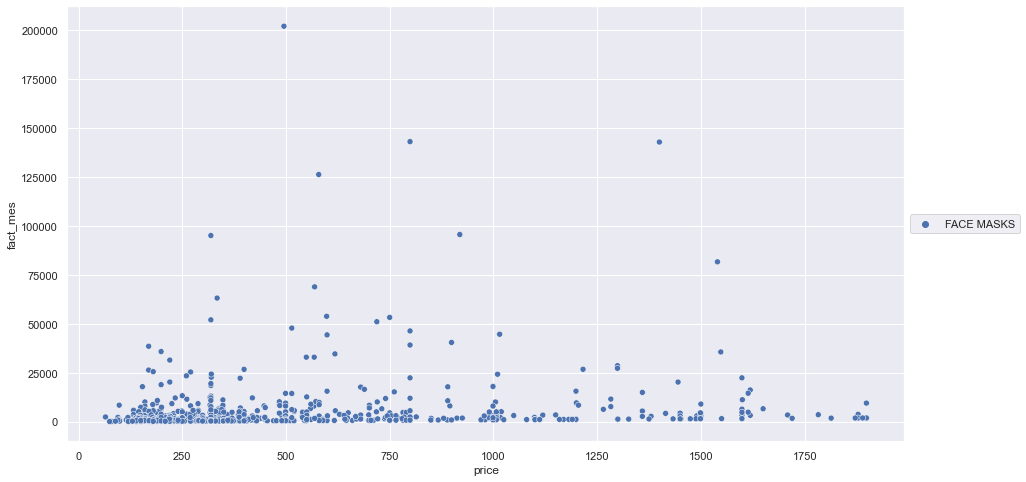

In [38]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.scatterplot(x='price', y='fact_mes', data=top_sellers, hue='domain_id').legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)


In [42]:
top_sellers.describe()

,price,sale_price,available_quantity,sold_quantity,original_price,official_store_id,order_backend,health,meses_venta,ventas_mes,fact_mes
count,709.000000,0.0,709.000000,709.000000,108.000000,76.000000,709.000000,709.000000,709.000000,709.000000,709.000000
mean,511.883963,NaN,151.277856,143.558533,674.699074,1538.118421,25.590973,0.832948,11.216440,13.221439,5612.551481
std,404.954261,NaN,698.515373,383.424366,720.623513,512.471761,14.315521,0.072758,10.552930,31.242496,15141.496067
min,65.000000,NaN,1.000000,1.000000,204.000000,145.000000,1.000000,0.440000,0.140031,1.000000,75.000000
25%,229.000000,NaN,1.000000,8.000000,367.500000,1359.000000,13.000000,0.800000,2.362785,1.000000,700.000000
50%,359.000000,NaN,1.000000,27.000000,399.000000,1447.500000,26.000000,0.880000,9.140232,4.000000,1628.000000
75%,660.000000,NaN,50.000000,92.000000,683.750000,1844.750000,38.000000,0.880000,14.851017,11.000000,4491.000000
max,1899.000000,NaN,5000.000000,3976.000000,4020.000000,2577.000000,50.000000,1.000000,66.571310,408.000000,201960.000000
